# Paper Replicate

Format of the input: **[batch_size, no_of_channels, height, width]**.

We will be replicating the [original Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929).

---

In [1]:
# Check GPU information
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import scripts.data_setup as data_setup
import scripts.engine as engine


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42

In [3]:
print(torch.__version__)
print(torchvision.__version__)

1.12.1
0.13.1a0


## 1. Get data ready (turn into tensor)
Our dataset is a subset of the Food101 dataset. Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing). Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?
- When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.
- The whole point is to speed up how fast you can experiment.

### 1.1 Get the data

In [3]:
import scripts.get_data as get_data
import os


url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
image_path = os.path.join(os.getcwd(), "data", "pizza_steak_sushi")
get_data.download_data(url=url, save_path_str=image_path)

c:\`MyFiles\Learning\MachineLearning\pytorch\data\pizza_steak_sushi directory already exists... skipping download


WindowsPath('c:/`MyFiles/Learning/MachineLearning/pytorch/data/pizza_steak_sushi')

In [4]:
# Check details about data

import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'c:\`MyFiles\Learning\MachineLearning\pytorch\data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'c:\`MyFiles\Learning\MachineLearning\pytorch\data\pizza_steak_sushi\test'.
There are 0 directories and 26 images in 'c:\`MyFiles\Learning\MachineLearning\pytorch\data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'c:\`MyFiles\Learning\MachineLearning\pytorch\data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'c:\`MyFiles\Learning\MachineLearning\pytorch\data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'c:\`MyFiles\Learning\MachineLearning\pytorch\data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'c:\`MyFiles\Learning\MachineLearning\pytorch\data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'c:\`MyFiles\Learning\MachineLearning\pytorch\data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images i

In [5]:
from pathlib import Path


# Setup train and testing paths
image_path = Path(image_path)
train_dir = image_path / "train"
test_dir = image_path / "test"

Random image path: c:\`MyFiles\Learning\MachineLearning\pytorch\data\pizza_steak_sushi\train\steak\461689.jpg
Image class: steak
Image height: 512
Image width: 341


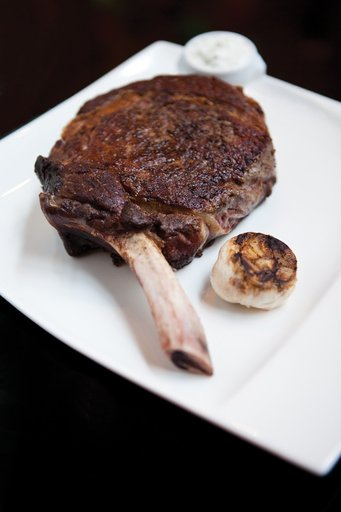

In [6]:
# Visualize the data (randomly take some images)

import random 
from PIL import Image

# Set seed
# random.seed(RANDOM_SEED)

# 1. Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata 
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 340.5, 511.5, -0.5)

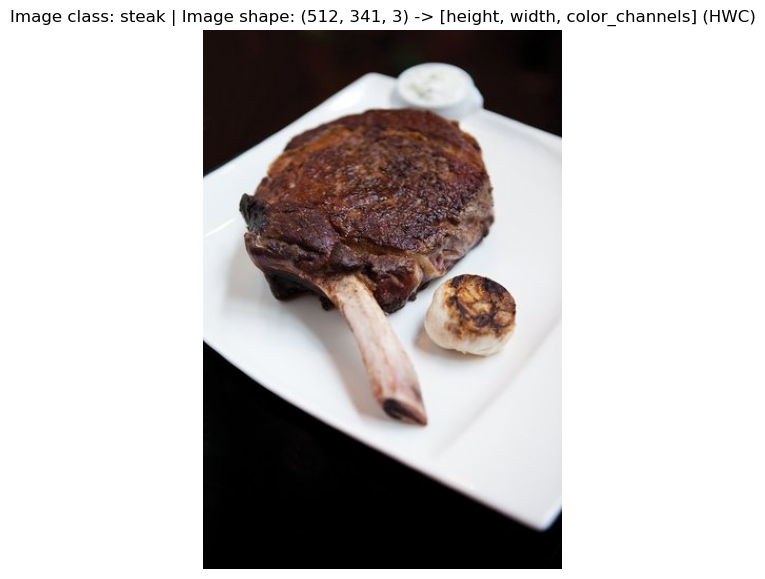

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)

### 1.2 Transform the data
It's important that your custom data going into the model is prepared in the same way as the original training data that went into the model. Two ways to do it:
1. Manually create the same transformation as used in the pre-trained model.
2. Automatically get the transofrmation used in the pre-trained model.
    - `EfficientNet_B0_Weights` is the model architecture weights we'd like to use 

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

print(f"Shape of image before transform: {img_as_array.shape}")
print(f"Shape of image after manual transform: {manual_transform(img).shape}")

Shape of image before transform: (512, 341, 3)
Shape of image after manual transform: torch.Size([3, 224, 224])


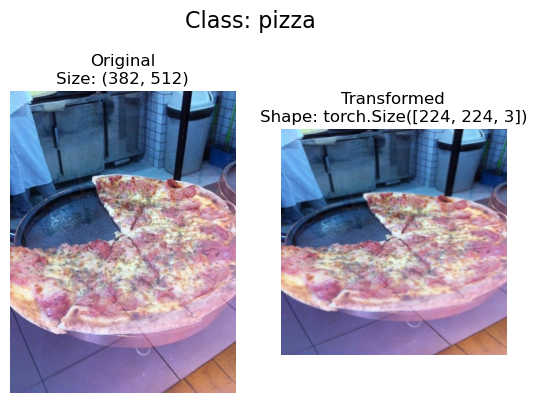

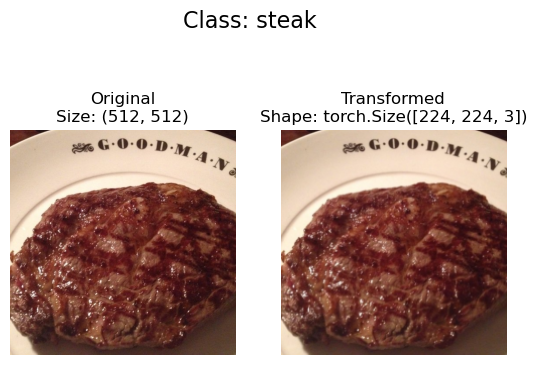

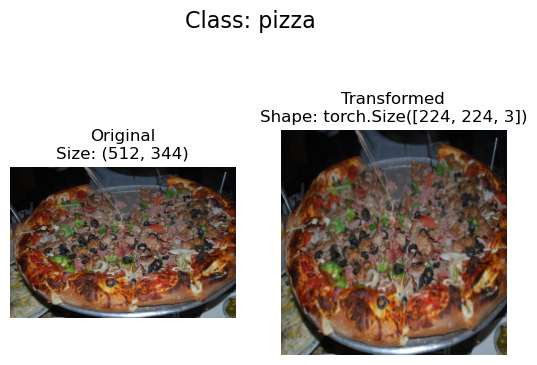

In [10]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=manual_transform,
                        n=3,
                        seed=None)

### 1.3 Convert data to pytorch dataset
We'll do this in next section.

### 1.4 Prepare DataLoader

In [11]:
from scripts.data_setup import create_dataloaders


# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1a0d18d0a90>,
 ['pizza', 'steak', 'sushi'])

train_features_batch: torch.Size([32, 3, 224, 224])
train_labels_batch: torch.Size([32])
Image size: torch.Size([3, 224, 224])
Label size: torch.Size([])


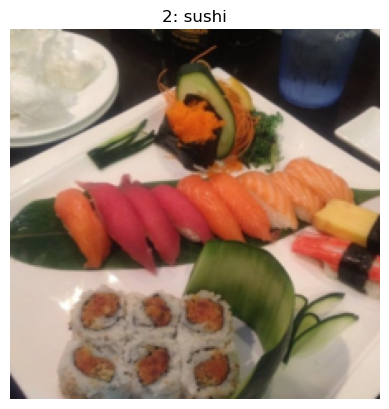

In [12]:
# Visualize one sample from train_dataloader
import numpy as np

train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"train_features_batch: {train_features_batch.shape}")
print(f"train_labels_batch: {train_labels_batch.shape}")

torch.manual_seed(RANDOM_SEED)
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]

img_as_array = np.asarray(img.permute(1, 2, 0))
plt.imshow(img_as_array)
plt.title(f"{label}: {class_names[label]}")
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label size: {label.shape}")

## 2. Build or pick a pretrained model for training

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model. A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

Here, we will be replicating the model from paper.

### 2.0 Replicate the ViT model from paper

#### 2.0.1 Calculating patch embedding input and output shapes by hand

In [13]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [14]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


#### 2.0.2 Turning a single image into patches

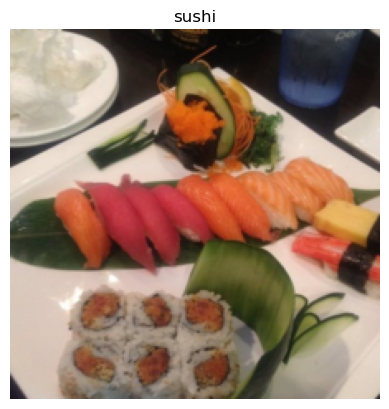

In [16]:
# View single image
plt.imshow(img.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

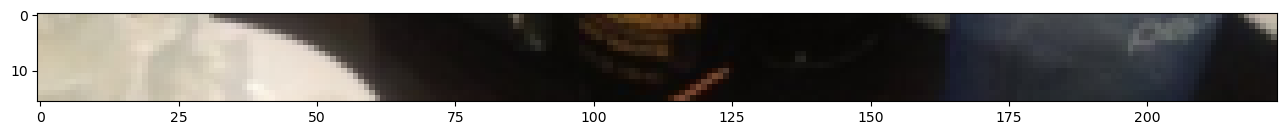

In [18]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = img.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


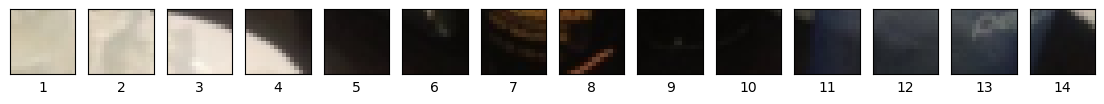

In [19]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


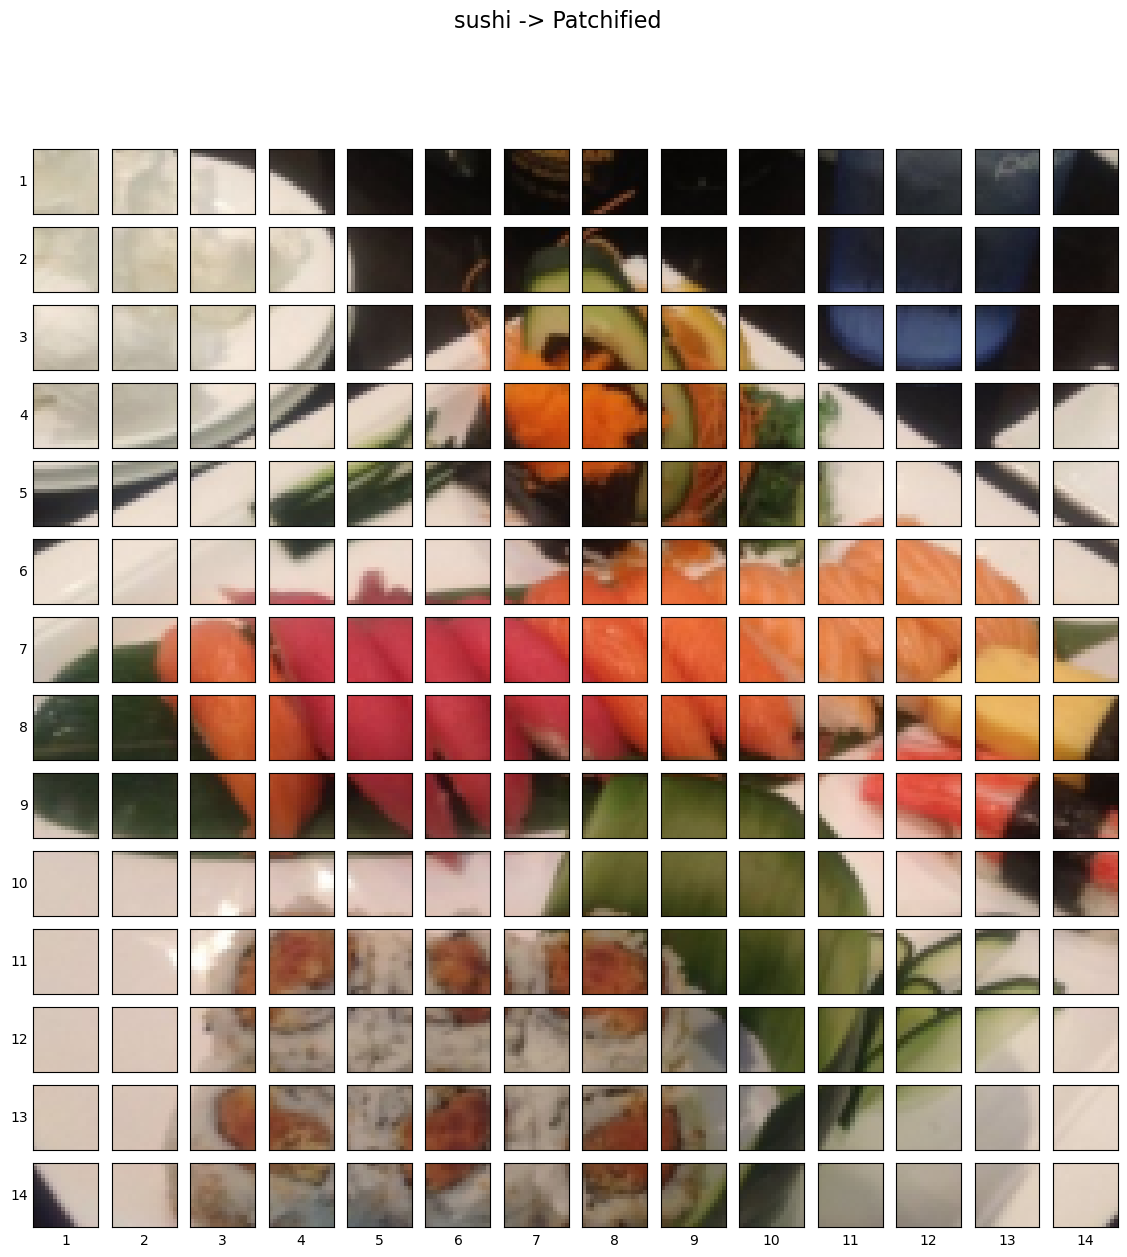

In [20]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

#### 2.0.3 Creating image patches with torch.nn.Conv2d()
We've seen what an image looks like when it gets turned into patches, now let's start moving towards replicating the patch embedding layers with PyTorch.

In [21]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

In [23]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(img.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(f"{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


Showing random convolutional feature maps from indexes: [470, 153, 741, 0, 113]


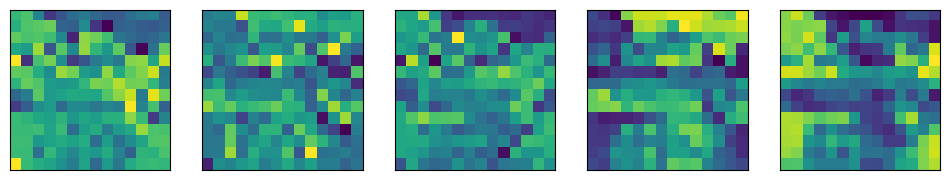

In [53]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

#### 2.0.4 Flattening the patch embedding with torch.nn.Flatten()

In [54]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [56]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


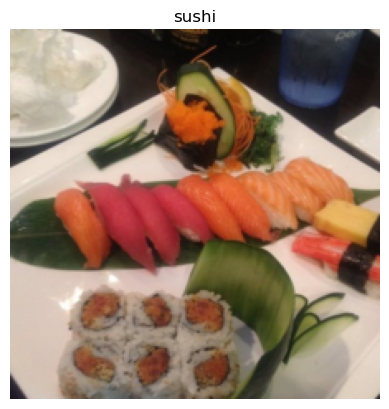

In [57]:
# Let's put it all together
# 1. View single image
plt.imshow(img.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {img.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(img.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [58]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


# ----------------- Done until here ------------------

### 2.1 Pick loss function and optimizer

### 2.2 Build a training loop to train the model

[INFO] Created SummaryWriter, saving to: runs\2023-05-14\data_10_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0883 | train_acc: 0.4180 | test_loss: 0.8897 | test_acc: 0.6944


 20%|██        | 1/5 [00:59<03:58, 59.63s/it]

Epoch: 2 | train_loss: 0.8937 | train_acc: 0.6641 | test_loss: 0.8064 | test_acc: 0.7847


 40%|████      | 2/5 [02:01<03:02, 60.76s/it]

Epoch: 3 | train_loss: 0.7450 | train_acc: 0.8438 | test_loss: 0.7478 | test_acc: 0.7465


 60%|██████    | 3/5 [03:01<02:01, 60.57s/it]

Epoch: 4 | train_loss: 0.7797 | train_acc: 0.6992 | test_loss: 0.6922 | test_acc: 0.7917


 80%|████████  | 4/5 [04:05<01:01, 61.77s/it]

Epoch: 5 | train_loss: 0.6322 | train_acc: 0.7695 | test_loss: 0.6440 | test_acc: 0.8438


100%|██████████| 5/5 [05:06<00:00, 61.36s/it]


Train time on cpu: 306.818 seconds
{'train_loss': [1.0882933586835861, 0.8936692401766777, 0.744956448674202, 0.7797179371118546, 0.6321721151471138], 'train_acc': [0.41796875, 0.6640625, 0.84375, 0.69921875, 0.76953125], 'test_loss': [0.8897400697072347, 0.806398610273997, 0.747843603293101, 0.6921968857447306, 0.6440375049908956], 'test_acc': [0.6944444444444445, 0.7847222222222222, 0.7465277777777778, 0.7916666666666666, 0.84375]}


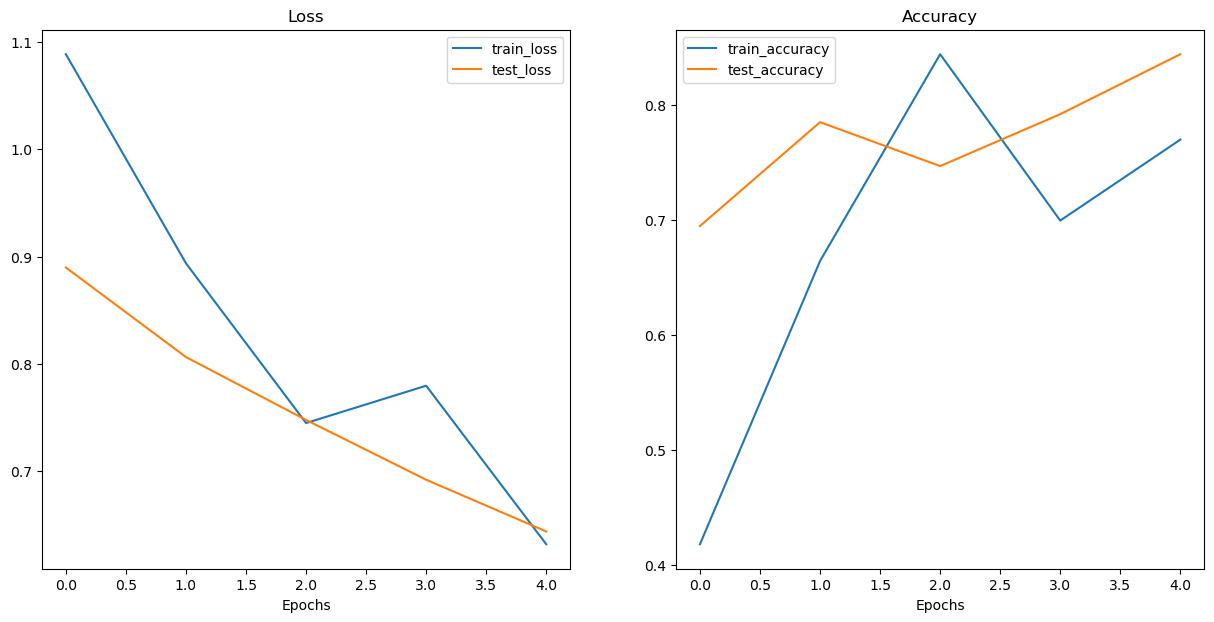

In [19]:
from timeit import default_timer as timer
from scripts.engine import train
from scripts.utils import print_train_time, plot_loss_curves, create_writer


torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

start_timer = timer()
# Setup training and save the results
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=DEVICE,
                writer=create_writer("data_10_percent", "effnetb0", "5_epochs"))
end_timer = timer()
train_time_0 = print_train_time(start_timer, end_timer, DEVICE)

print(results)
plot_loss_curves(results)

### 2.3 View model's results in TensorBoard

In [13]:
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir runs

## 3. Make prediction
One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in same format as the images our model was trained on.

This means we'll need to make sure our images have:
- Same shape - If our images are different shapes to what our model was trained on, we'll get shape errors.
- Same datatype - If our images are a different datatype (e.g. torch.int8 vs. torch.float32) we'll get datatype errors.
- Same device - If our images are on a different device to our model, we'll get device errors.
- Same transformations - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

In [ ]:
from scripts.utils import pred_and_plot_single_image
from pathlib import Path

# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_single_image(
        model=model, 
        image_path=image_path,
        class_names=class_names,
        transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
        # image_size=(224, 224)
    )

## 4. Evaluate the model

In [ ]:
from sklearn.metrics import accuracy_score
from scripts.utils import eval_model_classification


torch.manual_seed(RANDOM_SEED)
model_0_res = eval_model_classification(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_score
)
print(model_0_res)

In [ ]:
# Visualize random predictions
from scripts.utils import make_predictions

# random.seed(RANDOM_SEED)
y_preds = make_predictions(model, test_dataloader)

test_data = test_dataloader.dataset
rows, cols = 3, 3
fig = plt.figure(figsize=(9, 9))
for i in range(1, rows * cols + 1):
  rand_idx = torch.randint(0, len(test_data), size=[1]).item()
  X, y_truth = test_data[rand_idx]
  y_truth = class_names[y_truth]
  y_pred = class_names[y_preds[rand_idx]]
  fig.add_subplot(rows, cols, i)
  img_as_array = np.asarray(X.permute(1, 2, 0))
  plt.imshow(img_as_array)
  if y_pred == y_truth:
    plt.title(f"Truth: {y_truth} | Pred: {y_pred}", c="g")
  else:
    plt.title(f"Truth: {y_truth} | Pred: {y_pred}", c="r")
  plt.axis(False)

In [ ]:
from scripts.utils import make_predictions


# Make predictions with trained model
y_pred_tensor = make_predictions(model, test_dataloader, DEVICE)
y_pred_tensor

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

test_truth = torch.cat([y for X, y in test_dataloader])

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_truth)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)

## 5. Improve through experimentation
Let's try out the following:

| Experiment number | Training Dataset | Model (pretrained on ImageNet) | Number of epochs |
| --- | --- | --- | --- |
| 1	| Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 5 |
| 2	| Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 5 |
| 3	| Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 10 |
| 4	| Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 10 |
| 5	| Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 5 |
| 6	| Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 5 |
| 7	| Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 10 |
| 8	| Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 10 |

Notice how we're slowly scaling things up. With each experiment we slowly increase the amount of data, the model size and the length of training. By the end, experiment 8 will be using double the data, double the model size and double the length of training compared to experiment 1.

### 5.1 Download required datasets

In [ ]:
from scripts.get_data import download_data

# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     save_path_str="pizza_steak_sushi")

data_20_percent_path = download_data(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     save_path_str="pizza_steak_sushi_20_percent")

In [ ]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

### 5.2 Transform Datasets and create DataLoaders

In [ ]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [ ]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

### 5.3 Create feature extraction models

> Note: Whenever you use a different model, one of the first things you should inspect is the input and output shapes. That way you'll know how you'll have to prepare your input data/update the model to have the correct output shape.

In [ ]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

In [ ]:
import torchvision
from torch import nn
from scripts.utils import set_seeds

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(DEVICE)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(DEVICE)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(DEVICE)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(DEVICE)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

### 5.4 Create experiments and set up training code

In [ ]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [ ]:
%%time
from scripts.utils import save_model, create_writer
from scripts.engine import train

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=DEVICE,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"06_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

### 5.5 View experiments in TensorBoard

In [ ]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# ---------------------- DO NOT TRY THIS UNLESS REQUIRED ---------------------
# # Upload the results to TensorBoard.dev (uncomment to try it out)
# !tensorboard dev upload --logdir runs \
#     --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
#     --description "Comparing results of different model size, training data amount and training time."

## 6. Save and reload best trained model

In [ ]:
# Model has already been saved

In [ ]:
# Load the model
import os

# Setup the best model filepath
best_model_path = os.path.join(os.getcwd(), "models", "06_effnetb2_data_20_percent_10_epochs.pth")

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

In [ ]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

In [ ]:
# Import function to make predictions on images and plot them 
from scripts.utils import pred_and_plot_single_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_single_image(
        model=best_model,
        image_path=image_path,
        class_names=class_names,
        transform=torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()
        # image_size=(224, 224)
    )

In [ ]:
# Evaluate loaded model
from scripts.utils import eval_model_classification
from sklearn.metrics import accuracy_score


torch.manual_seed(RANDOM_SEED)

best_model_results = eval_model_classification(
    model=best_model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_score
)

best_model_results

In [ ]:
from scripts.utils import make_predictions


# Make predictions with trained model
y_pred_tensor = make_predictions(best_model, test_dataloader, DEVICE)
y_pred_tensor

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

test_truth = torch.cat([y for X, y in test_dataloader])

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_truth)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)

## 7. Making prediciton on a custom image

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = image_path.parent / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

In [ ]:
from scripts.utils import pred_and_plot_single_image

# Pred on our custom image
pred_and_plot_single_image(
    model=best_model,
    image_path=custom_image_path,
    class_names=class_names,
    transform=torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms(),
    device=DEVICE
)